In [113]:
import sys
import json
from pathlib import Path
sys.path.append('/code/src')
from helper import get_segments, df_ann_test, sr_num_frames_test, SegmentDataset, sr_num_frames

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_ann_test

,video,label,s1,e1,s2,e2,raw_label,raw_rel_video_path,rel_video_path
0,Abuse028_x264.mp4,Abuse,165,240,-1,-1,Abuse,Abuse/Abuse028_x264.mp4,Abuse/Abuse028_x264.mp4
1,Abuse030_x264.mp4,Abuse,1275,1360,-1,-1,Abuse,Abuse/Abuse030_x264.mp4,Abuse/Abuse030_x264.mp4
2,Arrest001_x264.mp4,Arrest,1185,1485,-1,-1,Arrest,Arrest/Arrest001_x264.mp4,Arrest/Arrest001_x264.mp4
3,Arrest007_x264.mp4,Arrest,1530,2160,-1,-1,Arrest,Arrest/Arrest007_x264.mp4,Arrest/Arrest007_x264.mp4
4,Arrest024_x264.mp4,Arrest,1005,3105,-1,-1,Arrest,Arrest/Arrest024_x264.mp4,Arrest/Arrest024_x264.mp4
...,...,...,...,...,...,...,...,...,...
285,Vandalism007_x264.mp4,Vandalism,240,750,-1,-1,Vandalism,Vandalism/Vandalism007_x264.mp4,Vandalism/Vandalism007_x264.mp4
286,Vandalism015_x264.mp4,Vandalism,2010,2700,-1,-1,Vandalism,Vandalism/Vandalism015_x264.mp4,Vandalism/Vandalism015_x264.mp4
287,Vandalism017_x264.mp4,Vandalism,270,330,780,840,Vandalism,Vandalism/Vandalism017_x264.mp4,Vandalism/Vandalism017_x264.mp4
288,Vandalism028_x264.mp4,Vandalism,1830,1980,2400,2670,Vandalism,Vandalism/Vandalism028_x264.mp4,Vandalism/Vandalism028_x264.mp4


In [ ]:
p_rootdir = Path('/code/output/psuedo-captions/gpt-4o/00-rich-context')
# p_scores_dir1 = p_rootdir / 'scored,imagebind,1.0'
# p_scores_dir2 = p_rootdir / 'scored,imagebind,0.8'

In [47]:
ann_vad = {}
for idx, row in df_ann_test.iterrows():
    num_frames = sr_num_frames_test[row['raw_rel_video_path']]
    bin_label = np.zeros(num_frames, dtype=np.int32)
    bin_label[row['s1']:row['e1']] = 1
    if row['s2'] != -1:
        bin_label[row['s2']:row['e2']] = 1
    ann_vad[row['rel_video_path']] = bin_label

preds_per_scale = []
gaussian_kernel = np.array([.1, .2, .4, .2, .1])
for scale in [1.0, 0.9, 0.8, 0.7]:
    p_scores_dir = p_rootdir / f'scored,imagebind,{scale:.1f}'
    preds = {}
    for rel_video_path, bin_label in ann_vad.items():
        p_json = (p_scores_dir / rel_video_path).with_suffix('.json')
        video_record = json.load(p_json.open())
        segment_records = video_record['segment_records']
        pred = np.zeros(len(bin_label))
        overlap_count = np.zeros(len(bin_label))
        for segment_record in segment_records:
            segment_score = np.mean(segment_record['is_anomalous'])  # anomality of all captions
            pred[segment_record['start_idx']:segment_record['end_idx']+1] += segment_score
            overlap_count[segment_record['start_idx']:segment_record['end_idx']+1] += 1
        overlap_count = np.maximum(overlap_count, 1)
        preds[rel_video_path] = pred / overlap_count
        preds[rel_video_path] = np.convolve(preds[rel_video_path], gaussian_kernel, mode='same')  # gaussian smoothing
    preds_per_scale.append(preds)

    all_preds, all_labels = np.array([]), np.array([])
    for rel_video_path, bin_label in ann_vad.items():
        all_preds = np.concatenate([all_preds, preds[rel_video_path]])
        all_labels = np.concatenate([all_labels, bin_label])
    auc = roc_auc_score(all_labels.astype(int), all_preds)
    print(f'Scale: {scale:.1f} | AUC: {auc:.4f}')

Scale: 1.0 | AUC: 0.6066
Scale: 0.9 | AUC: 0.7559
Scale: 0.8 | AUC: 0.8107
Scale: 0.7 | AUC: 0.7265


FileNotFoundError: [Errno 2] No such file or directory: '/code/output/psuedo-captions/gpt-4o/00-rich-context/scored,imagebind,0.0/Abuse/Abuse028_x264.json'

In [54]:
all_labels.astype(int).mean()

0.0757163107299102

In [30]:
action_classes = df_ann_test['label'].unique()
records = []
for preds, scale in zip(preds_per_scale, [1.0, 0.9, 0.8, 0.7]):
    for action_class in action_classes:
        all_preds, all_labels = np.array([]), np.array([])
        for rel_video_path, bin_label in ann_vad.items():
            if df_ann_test[df_ann_test['rel_video_path'] == rel_video_path]['label'].values[0] != action_class:
                continue
            all_preds = np.concatenate([all_preds, preds[rel_video_path]])
            all_labels = np.concatenate([all_labels, bin_label])
        if action_class == 'Normal':
            all_preds = np.concatenate([all_preds, [1]])
            all_labels = np.concatenate([all_labels, [1]])
        auc = roc_auc_score(all_labels.astype(int), all_preds)
        # print(f'{action_class}: {auc}')
        records.append({'scale': scale, 'action_class': action_class, 'auc': auc})
df_scores = pd.DataFrame(records)

0.5
0.5686689877495346
0.43133101225046544


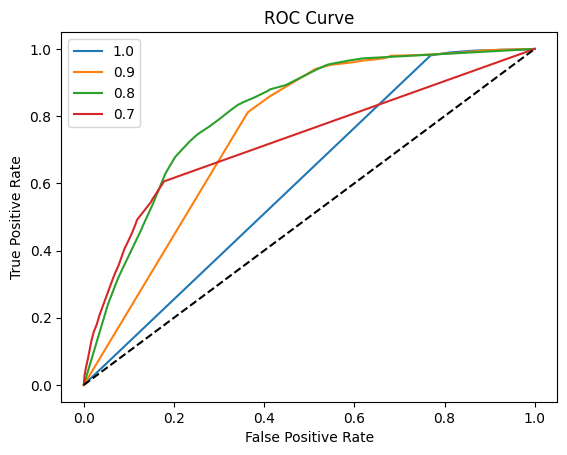

In [78]:
print(roc_auc_score(all_labels.astype(int), [0] * len(all_preds)))
print(roc_auc_score(all_labels.astype(int), [1] * (len(all_preds) // 2) + [0] * (len(all_preds) // 2)))
print(roc_auc_score(all_labels.astype(int), [0] * (len(all_preds) // 2) + [1] * (len(all_preds) // 2)))
for preds, scale in zip(preds_per_scale, [1.0, 0.9, 0.8, 0.7]):
    fpr, tpr, thresholds = roc_curve(
        all_labels.astype(int),
        np.concatenate([x[1] for x in sorted(preds.items(), key=lambda x: x[0])])
    )
    plt.plot(fpr, tpr, label=f'{scale:.1f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

In [38]:
df_scores_pivot = df_scores.pivot(index='action_class', columns='scale', values='auc').iloc[:, ::-1]
df_scores_pivot

scale,1.0,0.9,0.8,0.7
action_class,,,,
Abuse,0.504292,0.516452,0.409058,0.501720
Arrest,0.508195,0.554953,0.568751,0.581387
Arson,0.502494,0.667930,0.677356,0.572500
Assault,0.499929,0.691833,0.840597,0.853818
Burglary,0.502831,0.610086,0.613973,0.618479
Explosion,0.506028,0.484311,0.588619,0.697206
Fighting,0.511693,0.556399,0.543673,0.449720
Normal,0.349241,0.788639,0.990453,1.000000
RoadAccidents,0.524856,0.590035,0.571846,0.529406


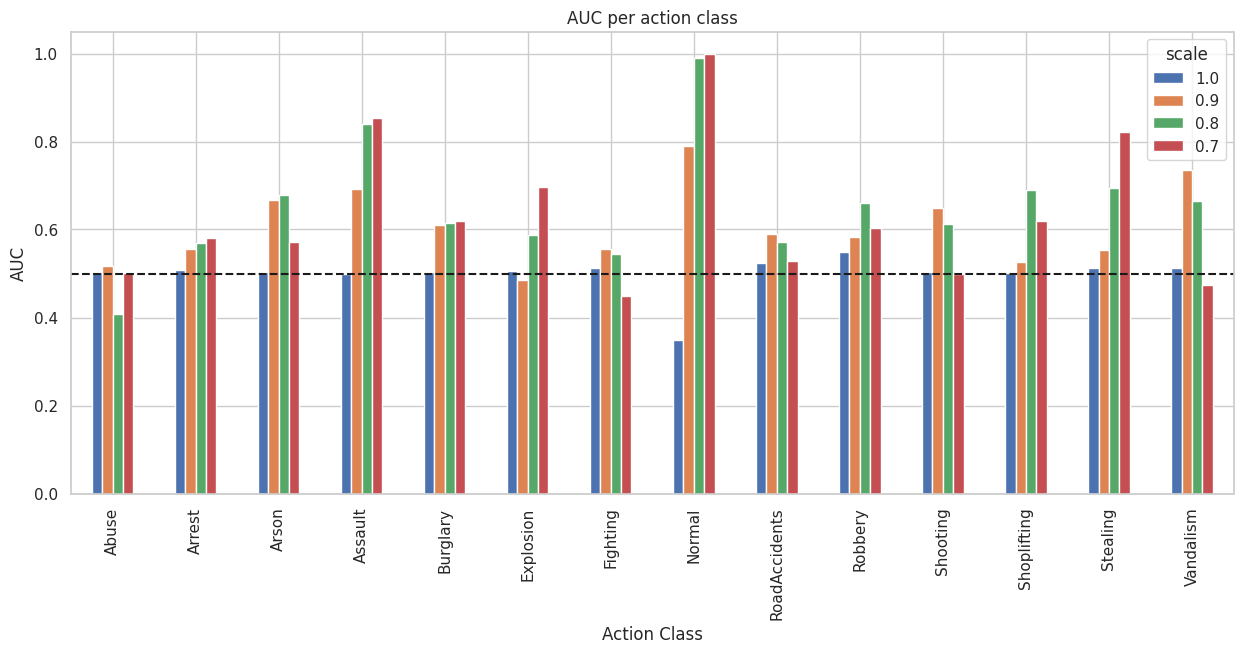

In [145]:
df_scores_pivot.plot(
    kind='bar',
    figsize=(15, 6),
    title='AUC per action class',
    xlabel='Action Class',
    ylabel='AUC',
)
plt.hlines(y=0.5, xmin=-.5, xmax=len(action_classes), color='k', linestyle='--')
plt.show()

In [97]:
df_ann_test

,video,label,s1,e1,s2,e2,raw_label,raw_rel_video_path,rel_video_path
0,Abuse028_x264.mp4,Abuse,165,240,-1,-1,Abuse,Abuse/Abuse028_x264.mp4,Abuse/Abuse028_x264.mp4
1,Abuse030_x264.mp4,Abuse,1275,1360,-1,-1,Abuse,Abuse/Abuse030_x264.mp4,Abuse/Abuse030_x264.mp4
2,Arrest001_x264.mp4,Arrest,1185,1485,-1,-1,Arrest,Arrest/Arrest001_x264.mp4,Arrest/Arrest001_x264.mp4
3,Arrest007_x264.mp4,Arrest,1530,2160,-1,-1,Arrest,Arrest/Arrest007_x264.mp4,Arrest/Arrest007_x264.mp4
4,Arrest024_x264.mp4,Arrest,1005,3105,-1,-1,Arrest,Arrest/Arrest024_x264.mp4,Arrest/Arrest024_x264.mp4
...,...,...,...,...,...,...,...,...,...
285,Vandalism007_x264.mp4,Vandalism,240,750,-1,-1,Vandalism,Vandalism/Vandalism007_x264.mp4,Vandalism/Vandalism007_x264.mp4
286,Vandalism015_x264.mp4,Vandalism,2010,2700,-1,-1,Vandalism,Vandalism/Vandalism015_x264.mp4,Vandalism/Vandalism015_x264.mp4
287,Vandalism017_x264.mp4,Vandalism,270,330,780,840,Vandalism,Vandalism/Vandalism017_x264.mp4,Vandalism/Vandalism017_x264.mp4
288,Vandalism028_x264.mp4,Vandalism,1830,1980,2400,2670,Vandalism,Vandalism/Vandalism028_x264.mp4,Vandalism/Vandalism028_x264.mp4


In [96]:
sr_num_frames

video
Abuse/Abuse001_x264.mp4             2729
Abuse/Abuse002_x264.mp4              865
Abuse/Abuse003_x264.mp4             3699
Abuse/Abuse004_x264.mp4            16794
Abuse/Abuse005_x264.mp4              949
                                   ...  
Vandalism/Vandalism046_x264.mp4     2099
Vandalism/Vandalism047_x264.mp4     2483
Vandalism/Vandalism048_x264.mp4     7183
Vandalism/Vandalism049_x264.mp4     7999
Vandalism/Vandalism050_x264.mp4      899
Name: num_frames, Length: 1900, dtype: int64

In [182]:
df_ann_joined = df_ann_test.join(sr_num_frames, on='raw_rel_video_path')
df_ann_joined['num_pos_frames'] = df_ann_joined['e1'] - df_ann_joined['s1'] + 1 + df_ann_joined['e2'] - df_ann_joined['s2'] + 1
df_ann_joined.loc[df_ann_joined['s1'] == -1, 'num_pos_frames'] -= 1
df_ann_joined.loc[df_ann_joined['s2'] == -1, 'num_pos_frames'] -= 1
df_ann_joined

,video,label,s1,e1,s2,e2,raw_label,raw_rel_video_path,rel_video_path,num_frames,num_pos_frames
0,Abuse028_x264.mp4,Abuse,165,240,-1,-1,Abuse,Abuse/Abuse028_x264.mp4,Abuse/Abuse028_x264.mp4,1412,76
1,Abuse030_x264.mp4,Abuse,1275,1360,-1,-1,Abuse,Abuse/Abuse030_x264.mp4,Abuse/Abuse030_x264.mp4,1544,86
2,Arrest001_x264.mp4,Arrest,1185,1485,-1,-1,Arrest,Arrest/Arrest001_x264.mp4,Arrest/Arrest001_x264.mp4,2374,301
3,Arrest007_x264.mp4,Arrest,1530,2160,-1,-1,Arrest,Arrest/Arrest007_x264.mp4,Arrest/Arrest007_x264.mp4,3144,631
4,Arrest024_x264.mp4,Arrest,1005,3105,-1,-1,Arrest,Arrest/Arrest024_x264.mp4,Arrest/Arrest024_x264.mp4,3629,2101
...,...,...,...,...,...,...,...,...,...,...,...
285,Vandalism007_x264.mp4,Vandalism,240,750,-1,-1,Vandalism,Vandalism/Vandalism007_x264.mp4,Vandalism/Vandalism007_x264.mp4,1146,511
286,Vandalism015_x264.mp4,Vandalism,2010,2700,-1,-1,Vandalism,Vandalism/Vandalism015_x264.mp4,Vandalism/Vandalism015_x264.mp4,2982,691
287,Vandalism017_x264.mp4,Vandalism,270,330,780,840,Vandalism,Vandalism/Vandalism017_x264.mp4,Vandalism/Vandalism017_x264.mp4,1011,122
288,Vandalism028_x264.mp4,Vandalism,1830,1980,2400,2670,Vandalism,Vandalism/Vandalism028_x264.mp4,Vandalism/Vandalism028_x264.mp4,4495,422


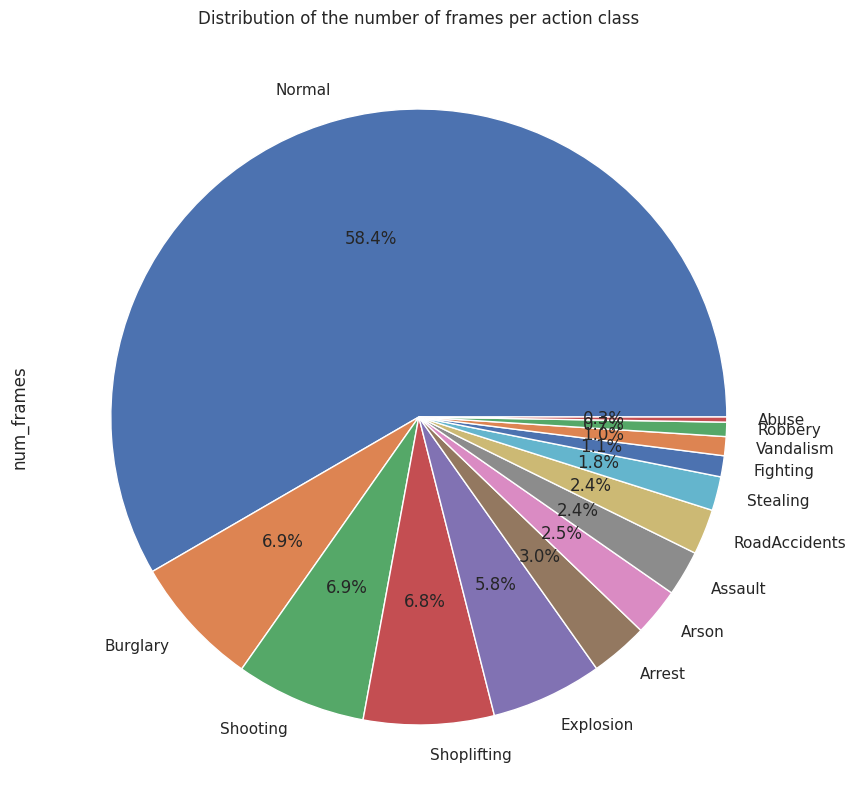

In [137]:
sr_num_frames_test_per_class = df_ann_joined.groupby('label')['num_frames'].sum()

sns.set_theme(style="whitegrid")

sr_num_frames_test_per_class.sort_values(ascending=False).plot.pie(
    figsize=(10, 10),
    title='Distribution of the number of frames per action class',
    autopct='%1.1f%%',
    # startangle=180,
    legend=False,
)
plt.show()

In [138]:
sr_num_frames_test_per_class

label
Abuse              2956
Arrest            33624
Arson             27888
Assault           26561
Burglary          76524
Explosion         64997
Fighting          12292
Normal           648905
RoadAccidents     26525
Robbery            8327
Shooting          76187
Shoplifting       76134
Stealing          19811
Vandalism         11077
Name: num_frames, dtype: int64

In [183]:
sr_num_pos_fraems_test_per_class = df_ann_joined.groupby('label')['num_pos_frames'].sum()
sr_num_pos_fraems_test_per_class

label
Abuse              162
Arrest            7820
Arson             8168
Assault           8520
Burglary         16104
Explosion         7633
Fighting          4438
Normal               0
RoadAccidents     2232
Robbery           3815
Shooting          9843
Shoplifting       7525
Stealing          6007
Vandalism         2078
Name: num_pos_frames, dtype: int64

,1.0,0.9,0.8,0.7,num_frames,num_pos_frames,num_neg_frames,frames_ratio,pos_frmaes_ratio,neg_frames_ratio,action_class_with_ratio
action_class_with_ratio,,,,,,,,,,,
"Normal (58.4%, 0.0%, 63.2%)",0.349241,0.788639,0.990453,1.000000,648905,0,648905,0.583648,0.000000,0.631560,"Normal (58.4%, 0.0%, 63.2%)"
"Burglary (6.9%, 19.1%, 5.9%)",0.502831,0.610086,0.613973,0.618479,76524,16104,60420,0.068828,0.190930,0.058805,"Burglary (6.9%, 19.1%, 5.9%)"
"Shooting (6.9%, 11.7%, 6.5%)",0.503798,0.649318,0.611626,0.499962,76187,9843,66344,0.068525,0.116699,0.064571,"Shooting (6.9%, 11.7%, 6.5%)"
"Shoplifting (6.8%, 8.9%, 6.7%)",0.500748,0.527000,0.689898,0.618792,76134,7525,68609,0.068478,0.089217,0.066775,"Shoplifting (6.8%, 8.9%, 6.7%)"
"Explosion (5.8%, 9.0%, 5.6%)",0.506028,0.484311,0.588619,0.697206,64997,7633,57364,0.058461,0.090497,0.055831,"Explosion (5.8%, 9.0%, 5.6%)"
"Arrest (3.0%, 9.3%, 2.5%)",0.508195,0.554953,0.568751,0.581387,33624,7820,25804,0.030243,0.092714,0.025114,"Arrest (3.0%, 9.3%, 2.5%)"
"Arson (2.5%, 9.7%, 1.9%)",0.502494,0.667930,0.677356,0.572500,27888,8168,19720,0.025083,0.096840,0.019193,"Arson (2.5%, 9.7%, 1.9%)"
"Assault (2.4%, 10.1%, 1.8%)",0.499929,0.691833,0.840597,0.853818,26561,8520,18041,0.023890,0.101014,0.017559,"Assault (2.4%, 10.1%, 1.8%)"
"RoadAccidents (2.4%, 2.6%, 2.4%)",0.524856,0.590035,0.571846,0.529406,26525,2232,24293,0.023858,0.026463,0.023644,"RoadAccidents (2.4%, 2.6%, 2.4%)"


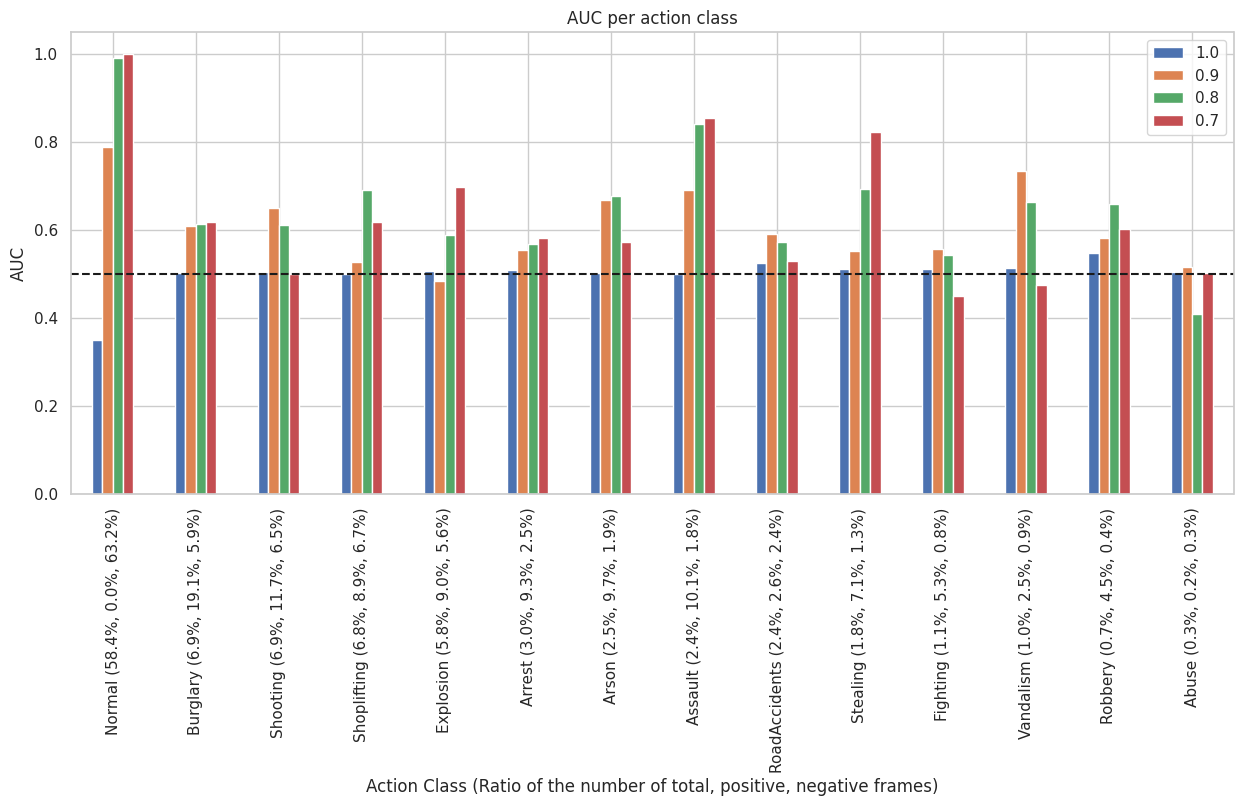

In [189]:
df_tmp = df_scores_pivot.join(sr_num_frames_test_per_class, on='action_class')
df_tmp = df_tmp.join(sr_num_pos_fraems_test_per_class, on='action_class')
df_tmp = df_tmp.join((sr_num_frames_test_per_class - sr_num_pos_fraems_test_per_class).rename('num_neg_frames'), on='action_class', rsuffix='_neg')
df_tmp['frames_ratio'] = df_tmp['num_frames'] / df_tmp['num_frames'].sum()
df_tmp['pos_frmaes_ratio'] = df_tmp['num_pos_frames'] / df_tmp['num_pos_frames'].sum()
df_tmp['neg_frames_ratio'] = df_tmp['num_neg_frames'] / df_tmp['num_neg_frames'].sum()
df_tmp['action_class_with_ratio'] = df_tmp.index + ' (' + df_tmp['frames_ratio'].apply(lambda x: f'{x:.1%}') + ', ' + df_tmp['pos_frmaes_ratio'].apply(lambda x: f'{x:.1%}') + ', ' + df_tmp['neg_frames_ratio'].apply(lambda x: f'{x:.1%}') + ')'

df_tmp.index = df_tmp['action_class_with_ratio']
df_tmp = df_tmp.sort_values(by='num_frames', ascending=False)
display(df_tmp)

df_tmp[[1.0, 0.9, 0.8, 0.7]].plot(
    kind='bar',
    figsize=(15, 6),
    title='AUC per action class',
    xlabel='Action Class (Ratio of the number of total, positive, negative frames)',
    ylabel='AUC',
)
plt.hlines(y=0.5, xmin=-.5, xmax=len(action_classes), color='k', linestyle='--')
# plt.xticks(rotation=45, ha='right')
plt.show()